In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [5]:
data = pd.read_csv('../ela_features_with_classes.csv')
data = data.drop(columns=['Unnamed: 0', 'function_id'])
X = data[['int', 'lr2', 'max', 'eps_ratio', 'disp', 'nbc']]
y = data['function_class']

In [7]:
scaler = StandardScaler()
#will be used later for clustering
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
preds_classification = knn.predict(X_scaled)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
preds_clusterization = kmeans.fit_predict(X_scaled)

In [19]:
best_alg_results = pd.read_csv('../optimization_results2.csv')
best_alg_results.head()

,Problem ID,Function ID,Instance ID,Algorithm,Best Solution (X),Best Function Value (F)
0,bbob_f001_i01_d20,1,1,PSO,"[0.25271295628667456, -1.1567240917649382, -0....",79.480001
1,bbob_f001_i01_d20,1,1,CMAES,"[0.2527999722638068, -1.1567999681501844, -0.7...",79.480000
2,bbob_f001_i01_d20,1,1,DE,"[0.23997986691433615, -1.173100748697348, -0.7...",79.493205
3,bbob_f001_i01_d20,1,1,L-BFGS-B,"[0.25280004924197097, -1.156800450762462, -0.7...",79.480000
4,bbob_f001_i01_d20,1,1,BIPOP-CMAES,"[0.2527999680449557, -1.1567999946809069, -0.7...",79.480000


In [20]:
def calculate_scores(group):
    group["Best Function Value (F)"] = group["Best Function Value (F)"].fillna(float('inf'))
    group["Score"] = group["Best Function Value (F)"].rank(method="dense", ascending=True).astype(int)
    group["Score"] = group["Score"].max() - group["Score"] + 1
    return group

best_alg_results = best_alg_results.groupby("Problem ID").apply(calculate_scores)

result = best_alg_results.pivot(index="Problem ID", columns="Algorithm", values="Score").reset_index()
result.fillna(0, inplace=True)

result.columns.name = None
result

,Problem ID,BIPOP-CMAES,CMAES,DE,L-BFGS-B,PSO
0,bbob_f001_i01_d20,5,4,1,3,2
1,bbob_f001_i02_d20,4,4,1,3,2
2,bbob_f001_i03_d20,4,4,1,3,2
3,bbob_f001_i04_d20,5,4,1,3,2
4,bbob_f001_i05_d20,5,4,1,3,2
...,...,...,...,...,...,...
1195,bbob_f024_i46_d20,5,4,3,1,2
1196,bbob_f024_i47_d20,5,4,2,1,3
1197,bbob_f024_i48_d20,5,4,2,1,3
1198,bbob_f024_i49_d20,4,5,2,1,3


In [22]:
result['Classification class'] = preds_classification
result['Clusterization class'] = preds_clusterization
result

,Problem ID,BIPOP-CMAES,CMAES,DE,L-BFGS-B,PSO,Classification class,Clusterization class
0,bbob_f001_i01_d20,5,4,1,3,2,1,3
1,bbob_f001_i02_d20,4,4,1,3,2,1,3
2,bbob_f001_i03_d20,4,4,1,3,2,1,3
3,bbob_f001_i04_d20,5,4,1,3,2,1,3
4,bbob_f001_i05_d20,5,4,1,3,2,1,3
...,...,...,...,...,...,...,...,...
1195,bbob_f024_i46_d20,5,4,3,1,2,5,4
1196,bbob_f024_i47_d20,5,4,2,1,3,5,4
1197,bbob_f024_i48_d20,5,4,2,1,3,5,4
1198,bbob_f024_i49_d20,4,5,2,1,3,5,4


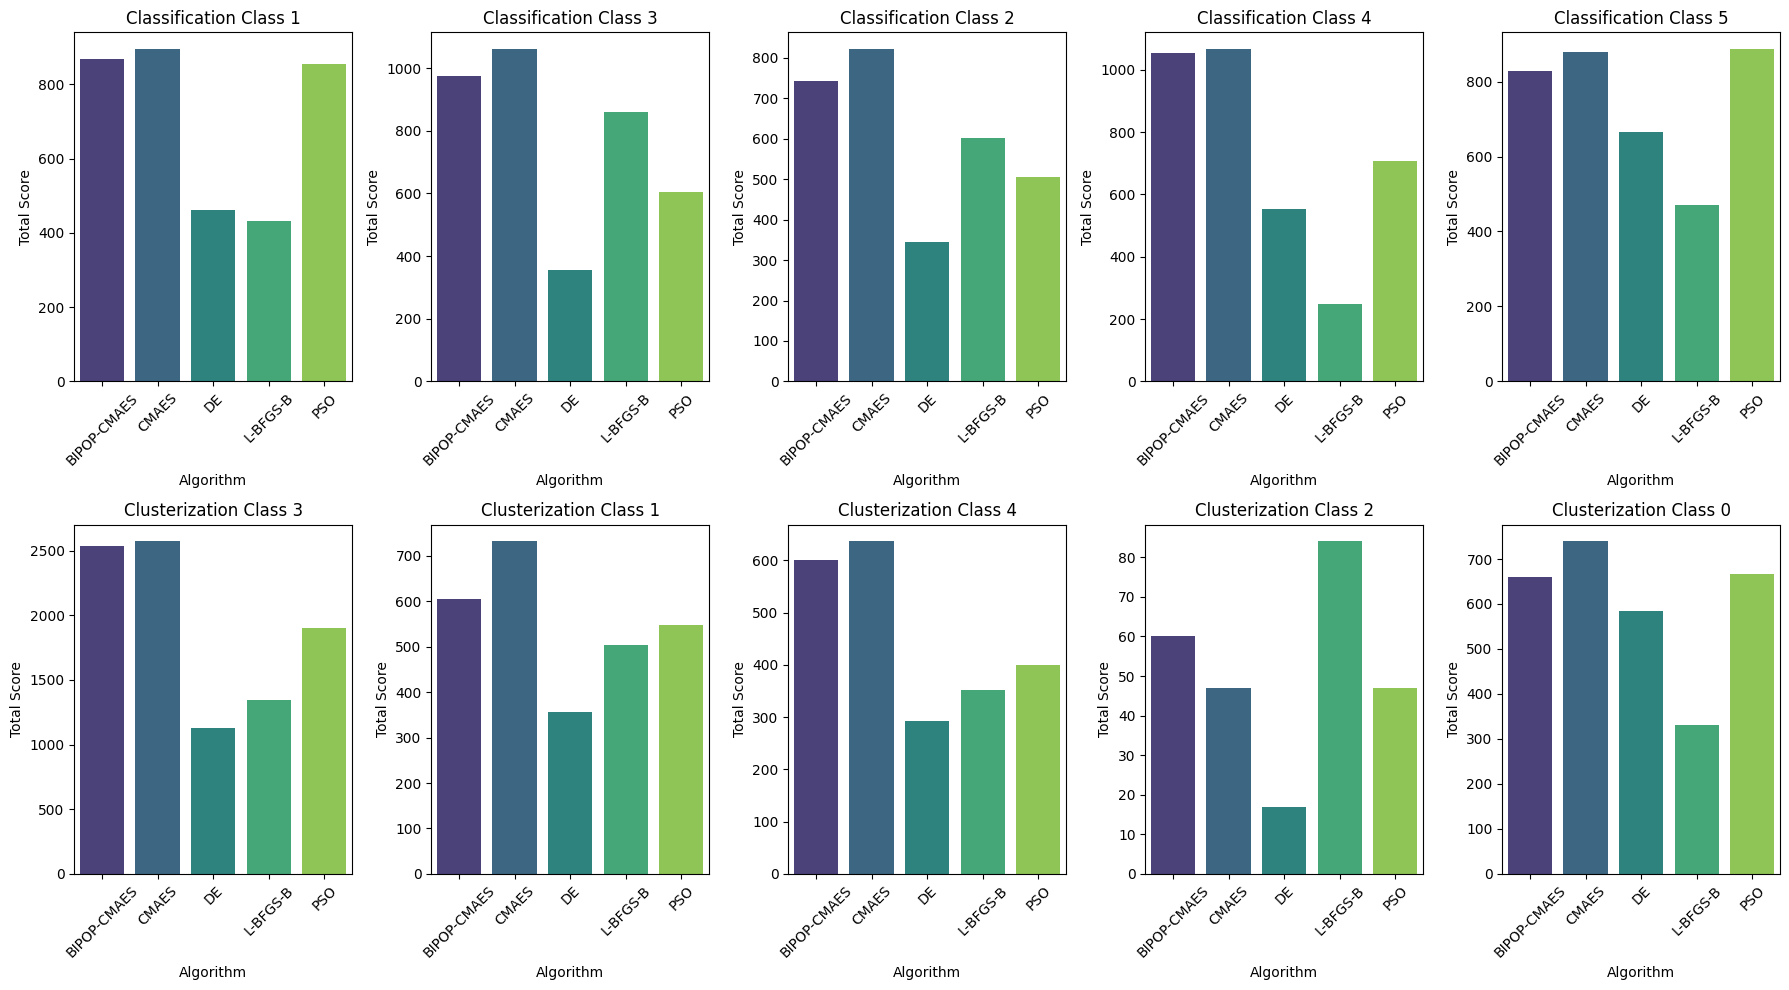

In [34]:
melted = result.melt(
    id_vars=["Classification class", "Clusterization class"],
    value_vars=["BIPOP-CMAES", "CMAES", "DE", "L-BFGS-B", "PSO"],
    var_name="Algorithm",
    value_name="Score",
)

classification_classes = melted["Classification class"].unique()
clusterization_classes = melted["Clusterization class"].unique()

num_classification_plots = len(classification_classes)
num_clusterization_plots = len(clusterization_classes)
fig, axes = plt.subplots(2, max(num_classification_plots, num_clusterization_plots), figsize=(18, 10))

for i, cls in enumerate(classification_classes):
    grouped = melted[melted["Classification class"] == cls].groupby("Algorithm")["Score"].sum().reset_index()
    sns.barplot(data=grouped, x="Algorithm", y="Score", ax=axes[0, i], palette="viridis", hue="Algorithm", legend=False)
    axes[0, i].set_title(f"Classification Class {cls}")
    axes[0, i].set_xlabel("Algorithm")
    axes[0, i].set_ylabel("Total Score")
    axes[0, i].tick_params(axis="x", rotation=45)

for i, cls in enumerate(clusterization_classes):
    grouped = melted[melted["Clusterization class"] == cls].groupby("Algorithm")["Score"].sum().reset_index()
    sns.barplot(data=grouped, x="Algorithm", y="Score", ax=axes[1, i], palette="viridis", hue="Algorithm", legend=False)
    axes[1, i].set_title(f"Clusterization Class {cls}")
    axes[1, i].set_xlabel("Algorithm")
    axes[1, i].set_ylabel("Total Score")
    axes[1, i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [37]:
from scipy.stats import chi2_contingency

df = result
algorithm_columns = ["BIPOP-CMAES", "CMAES", "DE", "L-BFGS-B", "PSO"]

df["Best Algorithms"] = df[algorithm_columns].apply(
    lambda row: row[row == row.max()].index.tolist(), axis=1
)

exploded_df = df.explode("Best Algorithms")

correlation_table = pd.crosstab(
    exploded_df["Classification class"],
    exploded_df["Best Algorithms"]
)
print(correlation_table)

chi2, p, dof, ex = chi2_contingency(correlation_table)
print(f"Chi2: {chi2}, p-value: {p}")

Best Algorithms       BIPOP-CMAES  CMAES  DE  L-BFGS-B  PSO
Classification class                                       
1                             134     84   0        51  123
2                              36     64   0        95    6
3                              35    118   0       100    4
4                             111    126   0         0    5
5                              60     69  32         9   85
Chi2: 661.7576707653741, p-value: 1.760587515214841e-130


The results suggest that there is a statistically significant association between the Classification class and the Best Algorithm. This implies that the choice of the best-performing algorithm is not random but is influenced by the classification class.

In [38]:
correlation_table = pd.crosstab(
    exploded_df["Clusterization class"],
    exploded_df["Best Algorithms"]
)
print(correlation_table)

chi2, p, dof, ex = chi2_contingency(correlation_table)
print(f"Chi2: {chi2}, p-value: {p}")

Best Algorithms       BIPOP-CMAES  CMAES  DE  L-BFGS-B  PSO
Clusterization class                                       
0                              45     83  32         7   38
1                              19     49   0        76   39
2                               0      1   0        16    0
3                             268    271   0       109  142
4                              44     57   0        47    4
Chi2: 399.1422564319526, p-value: 5.508573574286713e-75


Both tests confirm a significant relationship, but the magnitude of the chi-square statistic differs.
A smaller chi-square value (399.14) might suggest weaker differences in observed vs. expected values compared to the first test (661.76).